In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
from collections import Counter
import pandas as pd
import numpy as np

In [2]:
# Assuming a folder structure like: 'data/train/cancerous' and 'data/train/non-cancerous'
base_dir = '/Users/kylewong/Library/Mobile Documents/com~apple~CloudDocs/University of Colorado - Master of Data Science/Machine Learning/Neural Networks/histopathologic-cancer-detection/'


# Load CSV file
labels_df = pd.read_csv(base_dir + 'train_labels.csv')

# Check distribution of labels
class_counts = Counter(labels_df['label'])
print("Class distribution:", class_counts)


Class distribution: Counter({0: 130908, 1: 89117})


f38a6374c348f90b587e046aac6079959adf3835
755db6279dae599ebb4d39a9123cce439965282d
bc3f0c64fb968ff4a8bd33af6971ecae77c75e08
068aba587a4950175d04c680d38943fd488d6a9d
acfe80838488fae3c89bd21ade75be5c34e66be7


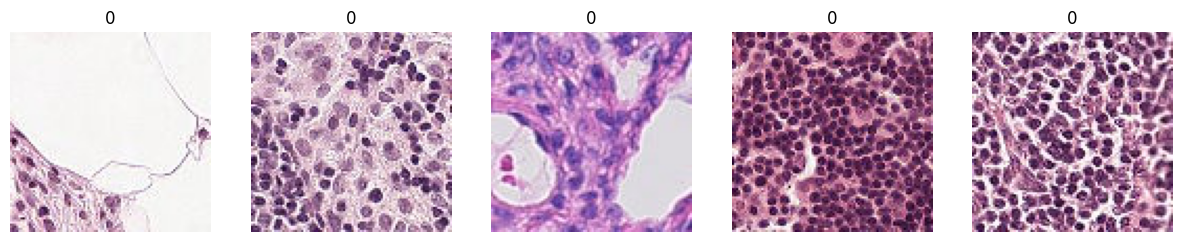

c18f2d887b7ae4f6742ee445113fa1aef383ed77
a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da
7f6ccae485af121e0b6ee733022e226ee6b0c65f
c3d660212bf2a11c994e0eadff13770a9927b731
94fa32b29cc1c00403176c0795fffa3cfaa0f20e


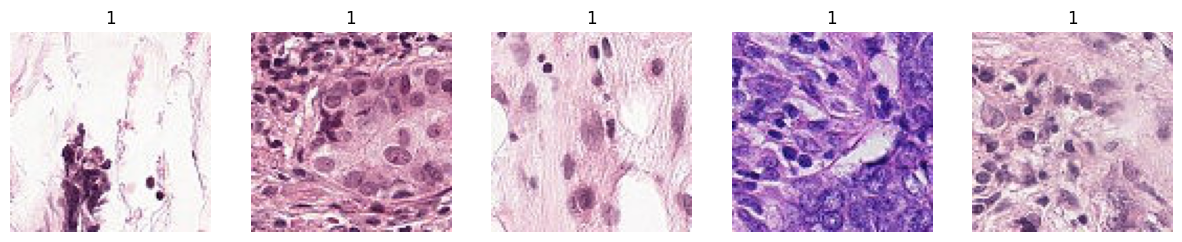

In [3]:
# Set up the image folder path
image_folder = base_dir + 'train/'

def show_samples(label, num_images=5):
    # Filter dataframe for specific label
    sample_images = labels_df[labels_df['label'] == label]['id'].values[:num_images]
    
    # Plot images
    plt.figure(figsize=(15, 5))
    for i, img_id in enumerate(sample_images):
        #trim img_id ending /
        img_id = img_id.rstrip('/')
        print(img_id)
        img_path = os.path.join(image_folder, img_id+'.tif' )
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()

# Display samples for each label
for label in labels_df['label'].unique():
    show_samples(label)


In [4]:
def analyze_image_dimensions():
    dimensions = []
    for img_id in labels_df['id'][0:100]:
        img_path = os.path.join(image_folder, img_id+'.tif')
        img = Image.open(img_path)
        dimensions.append(img.size)
    
    dimensions = np.array(dimensions)
    print(f"Mean dimensions: {np.mean(dimensions, axis=0)}, Std: {np.std(dimensions, axis=0)}")

analyze_image_dimensions()

Mean dimensions: [96. 96.], Std: [0. 0.]


In [5]:
def average_color(label):
    images = labels_df[labels_df['label'] == label]['id'][0:100]
    avg_colors = []

    for img_id in images:
        img_path = os.path.join(image_folder, img_id+'.tif')
        img = Image.open(img_path).resize((50, 50))  # resize for faster processing
        avg_colors.append(np.mean(np.array(img), axis=(0, 1)))

    avg_colors = np.array(avg_colors)
    return avg_colors.mean(axis=0)  # Mean color for the class

for label in labels_df['label'].unique():
    print(f"{label} class average color:", average_color(label))

0 class average color: [177.218476 141.709688 177.604604]
1 class average color: [177.136588 129.801072 177.5842  ]


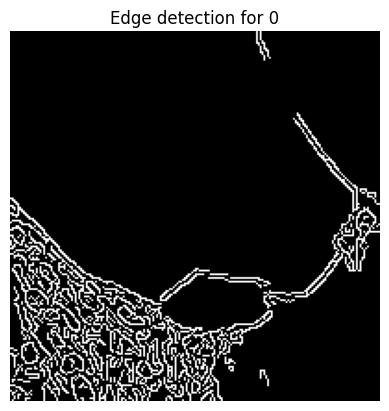

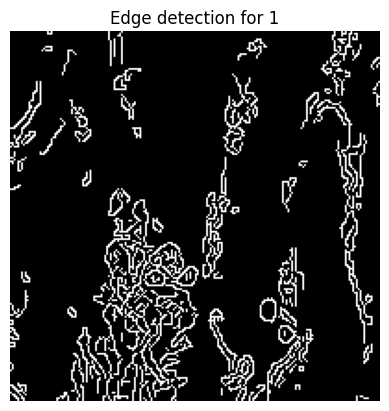

In [6]:


def edge_detection(label):
    img_id = labels_df[labels_df['label'] == label]['id'].values[0]  # Get a sample image ID
    img_path = os.path.join(image_folder, img_id+ '.tif')
    img = Image.open(img_path).convert('L').resize((200, 200))  # Convert to grayscale and resize
    edges = cv2.Canny(np.array(img), threshold1=100, threshold2=200)
    
    plt.imshow(edges, cmap='gray')
    plt.title(f"Edge detection for {label}")
    plt.axis('off')
    plt.show()

# Display edge detection for each label
for label in labels_df['label'].unique():
    edge_detection(label)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from collections import Counter

# Balance the dataset by downsampling the majority class (label 0)
class_0 = labels_df[labels_df['label'] == 0].sample(n=89117, random_state=42)
class_1 = labels_df[labels_df['label'] == 1]
balanced_df = pd.concat([class_0, class_1])

# Check the new class distribution
print("Balanced class distribution:", Counter(balanced_df['label']))

# Add '.tif' extension to image paths
balanced_df['id'] = balanced_df['id'].astype(str) + '.tif'
balanced_df['label'] = balanced_df['label'].astype(str)  # Convert labels to string for Keras compatibility

# Split data into training and validation sets
train_df, val_df = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df['label'], random_state=42)

# Image Data Generators for Training and Validation
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values
    horizontal_flip=True,     # Data augmentation
    rotation_range=15,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Flow data from the DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_folder,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'  # For binary classification
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_folder,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

# Define the CNN model using Keras
def create_cnn_model(input_shape=(96, 96, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary output
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize the model
model = create_cnn_model()

# Define a custom callback to print training progress
class TrainingProgressCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Print metrics at the end of each epoch
        print(f"Epoch {epoch + 1}: loss = {logs['loss']:.4f}, accuracy = {logs['accuracy']:.4f}, "
              f"val_loss = {logs['val_loss']:.4f}, val_accuracy = {logs['val_accuracy']:.4f}")

# Instantiate the callback
progress_callback = TrainingProgressCallback()

# Train the model with the callback
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[progress_callback]  # Add the callback here
)

# Save the model
model.save("cancer_detection_cnn.h5")

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.title('Training and Validation Metrics')
plt.show()